In [30]:
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib.colors import ListedColormap

In [31]:

def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)


def SIR(x, param_inf, param_rec, param_susceptible):
    """Function based on the following definition of SIR model:
    an healthy individual can be infected w.p. 1-(1-param_inf)^N where N are the infected neighbours around
    an infected individual can recover (and become again suscpetiple) w.p. param_rec

    """
    x = x.unsqueeze(0) # Add a dimension to the starting grid
    # Define the 3x3 kernel with all values set to 1
    kernel = torch.ones(1, 1, 3, 3, dtype=torch.float32)

    # and middle value to 0
    kernel[0][0][1][1] = 0

    # Perform convolution
    neighbors_count = F.conv2d(x.float(), kernel, padding=1)

    #GUMBEL - SOFTMAX TRICK THAT BEHAVES LIKE ~Bern(1-(1-beta)^N)
    #here I always keep the dimensionality of n x n
    bernoulli_param = 1-(1-param_inf)**neighbors_count

    ## add the feature that infected indivduals can recover w.p. param_rec

    #draw n x n Bernoulli distributed RV according to parameters described above
    random_uniform = torch.rand(x.size())
    y_pred = (bernoulli_param>=random_uniform).int()

    #y_pred[torch.logical_and(x == 1, random_uniform<=param_rec)] = 2
    y_pred[x == 1] = 1
    y_pred[x == 1] += (random_uniform[x==1]<=param_rec)

    y_pred[x == 2] = 2* (random_uniform[x==2]<=param_susceptible).int()

    # making sure that if a pixel was already infected, stays infected

    #making sure that an healthy pixel with no neighbours doesnt get infected
    y_pred[neighbors_count==0] = 0

    return y_pred.type(torch.FloatTensor)

In [32]:
n = 100
grid_size = (n,n)
grid = torch.zeros(grid_size, dtype=torch.int8)
grid[int(n/2),int(n/2)] = 1

tau = 50 #number of time step per simulation
nSim = 100 #number of simulations
res = torch.empty(tau*nSim,n,n)

#TRUE VALUES
betaInf = 0.333 #probability of infection
betaRec = 0.2   #probability of recovery
betaSus = 0.1   #probability of recovery

for i in range(tau*nSim):
    if i%tau==0:
        res[i] = grid
        continue
    next = SIR(res[i-1], betaInf, betaRec, betaSus)
    res[i] = next

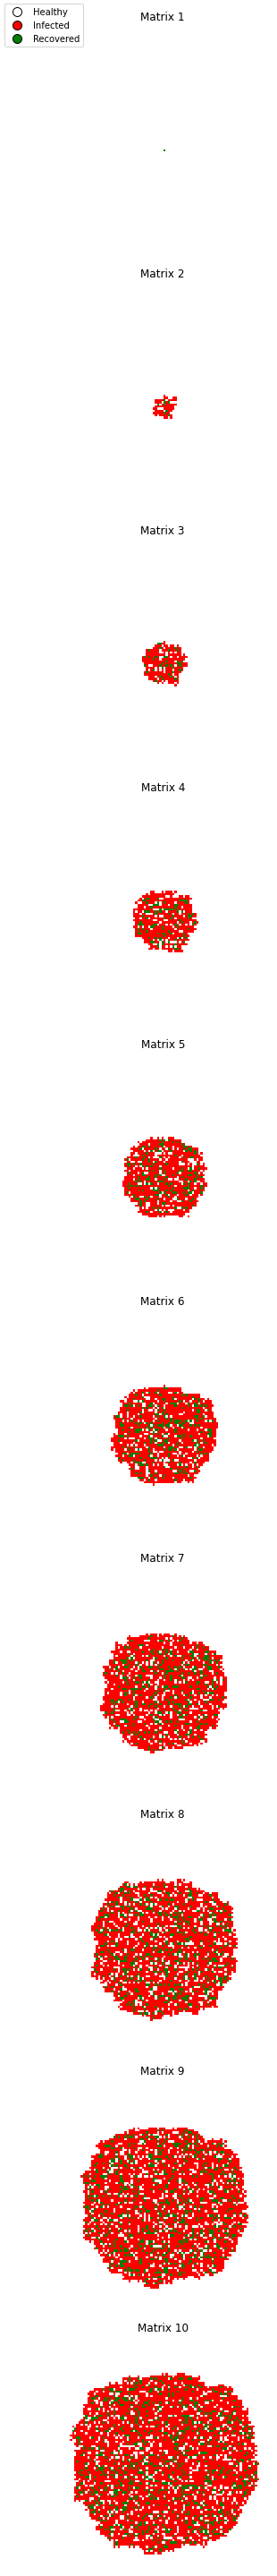

In [33]:
to_be_plotted = res[:50][::5]
fig, axs = plt.subplots(10, 1, figsize=(5, 40))

# Loop through each matrix and plot it using matshow

colors = ['white', 'red', 'green']
cmap = ListedColormap(colors)


for i in range(10):
    axs[i].matshow(to_be_plotted[i].numpy(), cmap=cmap)
    axs[i].set_title(f'Matrix {i+1}')
    axs[i].axis('off')  # Hide axes for better visualization

# Adjust layout to prevent overlap
legend_labels = ['Healthy', 'Infected', 'Recovered']
legend_colors = ['white', 'red', 'green']
markers = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, markeredgecolor='black') for color in legend_colors]

fig.legend(markers, legend_labels, loc='upper left')

plt.tight_layout()

# Show the plot
plt.show()

In [34]:
class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, sample_gumbel, temperature, paramInf, paramRec, paramSus):
        """Gumbel-softmax trick that given a list of values of N (neigbours),
        outputs whether every item in the list is accepted or not
        """
        """Gumbel-softmax trick that given a list of values of N (neigbours),
        outputs whether every item in the list is accepted or not
        """
        x = x.unsqueeze(0) # Add a dimension to the starting grid

        # Define the 3x3 kernel with all values set to 1
        kernel = torch.ones(1, 1, 3, 3, dtype=torch.float32)
        # and middle value to 0
        kernel[0][0][1][1] = 0

        # Perform convolution
        neighbors_count = F.conv2d(x, kernel, padding=1)
        x = x.squeeze()
        #GUMBEL - SOFTMAX TRICK THAT BEHAVES LIKE ~Bern(1-(1-beta)^N)
        #here I always keep the dimensionality of n x n


        logits_input = (1-(1-paramInf)**neighbors_count)

        #now I am gonna create 3 n x n matrices, so that for the indivisudual in position
        # x,y I can set straight away the probability of that to go to state 0,1,2 in the next
        # time step. Also the argmax function can then be computed directly
        #

        #the matrix of probabilities for individual in position x,y to go/stay to state 0 (susceptible) in the next time step
        suspectible_layer = torch.zeros(100,100)
        suspectible_layer[x==0] = 1-logits_input[0][x==0]
        suspectible_layer[x==2] = 1-paramSus

        #the matrix of probabilities for individual in position x,y to go/stay to state 1 (infected) in the next time step
        infected_layer = torch.zeros(100,100)
        infected_layer[x==0] = logits_input[0][x==0]
        infected_layer[x==1] = 1- paramRec

        #the matrix of probabilities for individual in position x,y to go/stay to state 2 (recovered) in the next time step
        recovered_layer = torch.zeros(100,100)
        recovered_layer[x==1] = paramRec
        recovered_layer[x==2] = paramSus

        logits = torch.log(torch.stack([suspectible_layer + 1e-10, infected_layer + 1e-10, recovered_layer + 1e-10], dim=0))

        softmax_input = logits + sample_gumbel
        #z = F.softmax(softmax_input / temperature, dim=0)
        z = softmax_input
        ctx.save_for_backward(x, sample_gumbel, torch.tensor([temperature]), paramInf, paramRec, z, neighbors_count)

        y_pred = z.argmax(dim=0)


        #making sure that an healthy pixel with no neighbours doesnt get infected
        y_pred[neighbors_count[0]==0] = 0
        #print(z[:, 33,44], x[33,44])
        return y_pred.type(torch.FloatTensor)

    @staticmethod
    def backward(ctx, grad_output):
        """"Straight through estimator
        """
        x, sample_gumbel, temperature, paramInf, paramRec, z, neighbours_count = ctx.saved_tensors
        grad_a = grad_output * (x==0)  # Custom gradient for paramInf that "pays attention" to susceptible indvidual
        grad_b = grad_output * (x==1)   # Custom gradient for paramInf that "pays attention" to infected indvidual
        grad_c = grad_output * (x==2)   # Custom gradient for paramInf that "pays attention" to infected indvidual

        return None, None, None, grad_a, grad_b, grad_c
        #return None, None, None, torch.tan(grad_output)  # <- return the identity function

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.a = nn.Parameter(torch.tensor([0.999]), requires_grad=True)  #initializing param 'a'
        self.b = nn.Parameter(torch.tensor([0.999]), requires_grad=True)  #initializing param 'a'
        self.c = nn.Parameter(torch.tensor([0.999]), requires_grad=True)  #initializing param 'a'

    def forward(self, x, sample_gumbel, temperature):
        x = STEFunction.apply(x, sample_gumbel, temperature, self.a, self.b, self.c)
        return x


In [35]:

model = MyModel()
optimizer = optim.SGD(model.parameters(), lr=0.001)
epochs = 15
predicted_parameter_inf = []
predicted_parameter_rec = []
predicted_parameter_sus = []

for epoch in range(epochs):
    for i in range(res.size()[0]-1):
        #skip when you reach the final time step of the simulation
        #if i %tau == 29:
        if i %tau == 49:
            continue

        gumbel_sample = sample_gumbel((3,n, n))
        input_data = res[i].type(torch.FloatTensor)
        y_pred= model(x = input_data, sample_gumbel = gumbel_sample, temperature = 0.1)

        loss =  torch.mean((y_pred - res[i+1])**2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        predicted_parameter_inf.append(model.a.item())
        predicted_parameter_rec.append(model.b.item())
        predicted_parameter_sus.append(model.b.item())

    print(model.a.item(), model.b.item(), model.c.item(), epoch)


0.9060181975364685 0.40740424394607544 0.6146548986434937 0
0.8199560046195984 0.25372031331062317 0.39421629905700684 1
0.7411301732063293 0.21410362422466278 0.2683315873146057 2
0.6699744462966919 0.20368970930576324 0.19630667567253113 3
0.6067248582839966 0.20110274851322174 0.15517641603946686 4
0.5515558123588562 0.20020152628421783 0.13184979557991028 5
0.5044770836830139 0.2001718431711197 0.1183633953332901 6
0.4650355279445648 0.2000095546245575 0.11050243675708771 7
0.43304523825645447 0.20011934638023376 0.10611379146575928 8
0.40756234526634216 0.20009580254554749 0.1035231500864029 9
0.3878733813762665 0.19993293285369873 0.10217294842004776 10
0.37289148569107056 0.19995790719985962 0.10134904086589813 11
0.36185747385025024 0.19998666644096375 0.1011529415845871 12
0.35358086228370667 0.19986560940742493 0.10078585147857666 13
0.34750401973724365 0.19991837441921234 0.10062576830387115 14


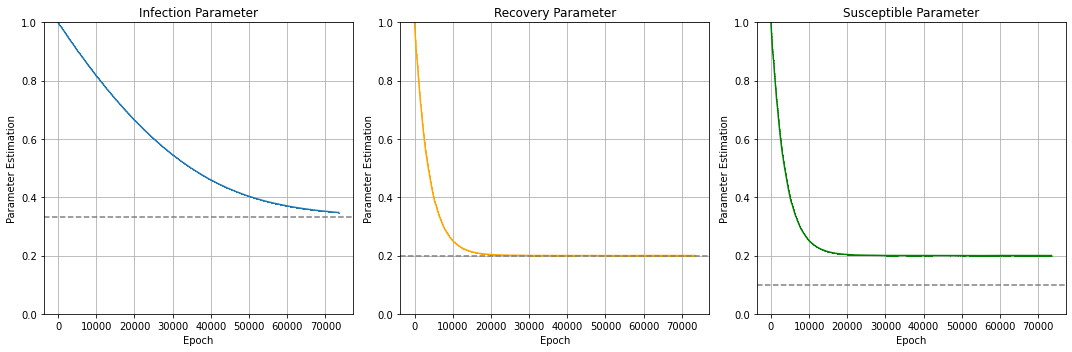

In [37]:
x_values = range(len(predicted_parameter_inf))

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Changed to 1 row, 3 columns

# Plot the first list
axs[0].plot(x_values, predicted_parameter_inf, marker='o', markersize=0.01)
axs[0].set_title('Infection Parameter')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Parameter Estimation')
axs[0].set_ylim(0, 1)
axs[0].axhline(y=betaInf, color='grey', linestyle='--')
axs[0].grid(True)

# Plot the second list
axs[1].plot(x_values, predicted_parameter_rec, marker='o', color='orange', markersize=0.01)
axs[1].set_title('Recovery Parameter')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Parameter Estimation')
axs[1].set_ylim(0, 1)
axs[1].axhline(y=betaRec, color='grey', linestyle='--')
axs[1].grid(True)

# Plot the third list (parameter_sus)
axs[2].plot(x_values, predicted_parameter_sus, marker='o', color='green', markersize=0.01)
axs[2].set_title('Susceptible Parameter')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Parameter Estimation')
axs[2].set_ylim(0, 1)
axs[2].axhline(y=betaSus, color='grey', linestyle='--')  # Assuming betaSus is defined
axs[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.grid(True)
plt.ylim(0)

# Show the plots
plt.show()